In [13]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [14]:
import gc
gc.collect()

3905

In [15]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device





Sat Sep 14 12:54:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 12%   54C    P2              61W / 250W |   1940MiB / 11264MiB |     14%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [16]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self,  output_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x

    

Using device: cuda


In [17]:
from stable_baselines3.common.env_util import make_atari_env
env_id="MsPacmanNoFrameskip-v4"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
# print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_atari_env(env_id, n_envs=1,wrapper_kwargs={"clip_reward":False})
from stable_baselines3.common.vec_env import VecFrameStack, VecTransposeImage
env = VecTransposeImage(env)            # 确保图像通道在前
env = VecFrameStack(env, n_stack=4)     # 堆叠4帧
obs = env.reset()
print(obs.shape)
# print(env.action_space.n)
# print(env.observation_space.shape[0])

(1154, 4, 84, 84) (1154,) (1154,) (1154,) (1154,) (1154, 4, 84, 84)
(1, 4, 84, 84)


In [18]:
obs = env.reset()
print(obs.shape)

(1, 4, 84, 84)


In [19]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32)
        self.actions = torch.tensor(actions, dtype=torch.float32)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [20]:
# 导入IPython显示控制模块

from tqdm import tqdm
policy_network = PolicyNetwork(env.action_space.n).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.conv1.weight)
torch.nn.init.kaiming_normal_(policy_network.conv2.weight)
torch.nn.init.kaiming_normal_(policy_network.conv3.weight)
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)

# prev = PolicyNetwork(env.action_space.n).to(device)
# prev.load_state_dict(policy_network.state_dict())
# prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=3e-4,weight_decay=1e-3)

# Training loop
num_epochs = 100000
batch_size = observations.shape[0]
mean=observations.mean()
std=observations.std()
print(mean.shape, std.shape)

Normlization=True
# dataset = mydataset(observations=observations, actions=actions)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
normalize_obs= (observations-mean)/std
loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
num_test = 1
if Normlization:
    obs_batch = torch.tensor(np.array(normalize_obs), dtype=torch.float32).to(device)
else:
    obs_batch = torch.tensor(np.array(observations), dtype=torch.float32).to(device)
act_batch = torch.tensor(np.array(actions), dtype=torch.float32).to(device)
test_score=0
for epoch in tqdm(range(1,1+num_epochs)):
    policy_network.train()

    # for step, (obs_batch,act_batch) in enumerate(pbar):
    


    
    logits = policy_network(obs_batch)
    model_dist = Categorical(logits=logits)
    model_act_sample = model_dist.sample()
    policy_chosen_logps = model_dist.log_prob(act_batch)
    policy_rejected_logps = model_dist.log_prob(model_act_sample)
        # with torch.no_grad():
        #     prev_dist = Categorical(logits=prev(obs_batch))
        #     reference_chosen_logps = prev_dist.log_prob(act_batch)
        #     reference_rejected_logps = prev_dist.log_prob(model_act_sample)


    pi_logratios = policy_chosen_logps - policy_rejected_logps
        # ref_logratios = reference_chosen_logps - reference_rejected_logps

    logits = pi_logratios

    chosen_logratios = policy_chosen_logps 
    reject_logratios = policy_rejected_logps


    beta = 0.1
    # losses = (-F.logsigmoid(beta * logits))-policy_chosen_logps
    # losses = (-F.logsigmoid(beta * logits))
    losses = -policy_chosen_logps
    loss = losses.mean()
    # Optimize the policy
    optimizer.zero_grad()



    loss.backward()

    optimizer.step()
    # pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
    positive_reward = chosen_logratios.detach().mean().item()
    negative_reward = reject_logratios.detach().mean().item()
    margin = positive_reward - negative_reward
    loss_graph.append(loss.detach().item())
    margin_graph.append(margin)
    positive_reward_graph.append(positive_reward)
    negative_reward_graph.append(negative_reward)
    # pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward, "test_score": test_score})

    if epoch % 500 == 0:
        total_reward=0

        policy_network.eval()  # 切换到评估模式


        total_reward=0
        # test the policy and save as the first test as gif
        frames = []
        saved_frame = False
        for _ in range(num_test):
            state = env.reset()
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
            done = False
            while not done:
                if Normlization:
                    state_tensor = torch.tensor((state-mean)/std, dtype=torch.float32).to(device)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
                with torch.no_grad():
                    action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()
                    
                state, reward, done, _ = env.step(action)  # 执行动作
                total_reward += reward
                if not saved_frame:
                    frame = env.render(mode="rgb_array")
                    frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
            if not saved_frame:
                saved_frame = True
                image_path = f"test_{epoch}.gif"
                imageio.mimsave("./gif/"+image_path, frames, duration=40)
        # print(total_reward/num_test)
        test_score = total_reward/num_test
        eval_rewards.append(total_reward/num_test)
        policy_network.train()  # 切换回训练模式
        print(f"Epoch [{epoch}/{num_epochs}] loss: {loss.detach().item()} positive_reward: {positive_reward} negative_reward: {negative_reward} margin: {positive_reward - negative_reward} test_score: {test_score}")


    



() ()


  0%|          | 37/100000 [00:00<36:43, 45.37it/s]


KeyboardInterrupt: 

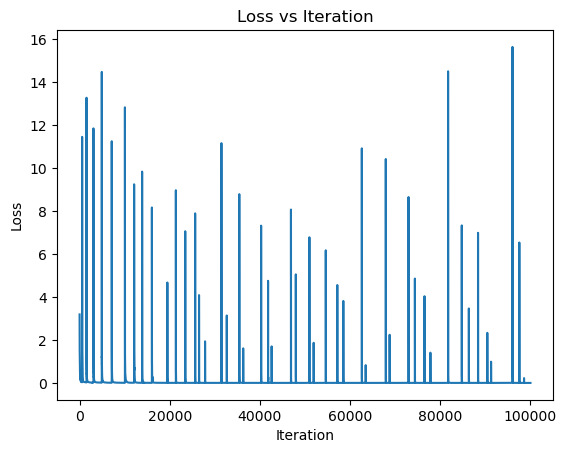

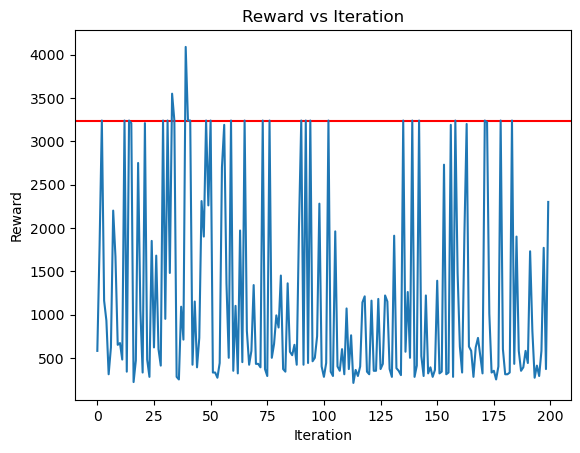

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.savefig("./loss.png")

plt.show()



# draw the reward graph
# draw a horizontal line at y=3240 which is the expert reward
plt.axhline(y=3240, color='r', linestyle='-', label="Expert Reward")
plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.savefig("./reward.png")
plt.show()


